# Imports

In [1]:
#Import
import numpy as np
import torch
import itertools

from torch import nn
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import transforms
from torchvision import datasets

from sklearn import metrics
from sklearn import mixture

from matplotlib import pyplot as plt

import random

# Download Model weight
!wget -O MNIST_Omniglot_GMM_4comp_model.pth https://www.dropbox.com/s/3ncaams6abkson9/MNIST_Omniglot_GMM_4comp_model.pth?dl=0

%matplotlib inline

cudnn.benchmark = True

args = {
    'batch_size': 200,    # Batch Size.
    'num_workers': 4,     # Dataloader threads.
    'num_classes': 10,    # Number of KKCs.
    'num_components': 4,  # Number of Components.
}

--2021-06-04 19:04:12--  https://www.dropbox.com/s/3ncaams6abkson9/MNIST_Omniglot_GMM_4comp_model.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3ncaams6abkson9/MNIST_Omniglot_GMM_4comp_model.pth [following]
--2021-06-04 19:04:12--  https://www.dropbox.com/s/raw/3ncaams6abkson9/MNIST_Omniglot_GMM_4comp_model.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc99744042a453eddfdb404205cb.dl.dropboxusercontent.com/cd/0/inline/BPxWux7lzUKmipL0JDM4EWta5aIRfYgkxNvwMwOeXG8VHRvGHlGq4SFuvpxmNbaRfV6SzKIdOEl8SGwEv-1pRHk7fpOQLFLkmLbBgrKbtK5rJ-2z0vUSvgvPtrpYl1eYN-W3A1CN1epc-tDpsT4Uv_kH/file# [following]
--2021-06-04 19:04:12--  https://uc99744042a453eddfdb404205cb.dl.dropboxusercontent.com/cd/0/inline/BPxWux7lzUKmipL0JDM

# Datasets

In [2]:
class Negative(object):
    
    def __init__(self):
        pass

    def __call__(self, image):

        image = image * -1.0

        return image

# Setting root dirs.
dir_omniglot = './OMNIGLOT/'
dir_mnist = './MNIST/'

common_transform = transforms.Compose([transforms.Resize(28),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)),])

ood_transform = transforms.Compose([transforms.Resize(28),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,)),
                                    Negative(),])

# Setting Closed Set Dataset.
mnist_train = datasets.MNIST(
    dir_mnist,
    train=True,
    download=True,
    transform=common_transform
)
mnist_test = datasets.MNIST(
    dir_mnist,
    train=False,
    download=True,
    transform=common_transform
)

mnist_train_loader = data.DataLoader(
    mnist_train,
    batch_size=args['batch_size'],
    num_workers=args['num_workers'],
    shuffle=True
)
mnist_test_loader = data.DataLoader(
    mnist_test,
    batch_size=args['batch_size'],
    num_workers=args['num_workers'],
    shuffle=False
)

# Setting Open Set Dataset.
omniglot_test = datasets.Omniglot(
    dir_omniglot,
    download=True,
    transform=ood_transform
)

omniglot_test_loader = data.DataLoader(
    omniglot_test,
    batch_size=args['batch_size'],
    num_workers=args['num_workers'],
    shuffle=False
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw




Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw




Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten


Extracting ./OMNIGLOT/omniglot-py/images_background.zip to ./OMNIGLOT/omniglot-py


# Model

In [3]:
#Create Model
model = models.resnet18().cuda()
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False).cuda()
model.fc = nn.Linear(in_features=512, out_features=args['num_classes'], bias=True).cuda()

#Load model
state = torch.load('./MNIST_Omniglot_GMM_4comp_model.pth')
model.load_state_dict(state)
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#Train GMM models

In [4]:
def train_gmm(cls_list, n_components):
    
    model = mixture.GaussianMixture(n_components=n_components, random_state=12345)
    
    model.fit(cls_list)
    
    return model

def train_gemos(mnist_train_loader, net):
    
    with torch.no_grad():
        
        # Setting network for evaluation mode (not computing gradients).
        net.eval()

        # Lists for output features.
        cls_list = [[] for c in range(args['num_classes'])]

        # Iterating over batches.
        for i, batch_data in enumerate(mnist_train_loader):

            # Obtaining images, labels and paths for batch.
            inps, labs = batch_data

            # Casting to cuda variables.
            inps = inps.cuda()

            # Forwarding.
            outs = net(inps)

            # Obtaining predictions.
            prds = outs.data.max(dim=1)[1].cpu().numpy()

            for j in range(prds.shape[0]):

                prds_cls = prds[j]
                labs_cls = labs[j].detach().cpu().item()

                if prds_cls == labs_cls:

                    cls_list[labs_cls].append(outs[j].detach().cpu().numpy().ravel())

        model_list = []

        for c in range(args['num_classes']):

            print('Training model for class %d...' % (c))
            model_list.append(train_gmm(np.asarray(cls_list[c]), args['num_components']))

        return model_list

model_list = train_gemos(mnist_train_loader, model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training model for class 0...
Training model for class 1...
Training model for class 2...
Training model for class 3...
Training model for class 4...
Training model for class 5...
Training model for class 6...
Training model for class 7...
Training model for class 8...
Training model for class 9...


#Test/Evaluation

In [5]:
def test_gemos(test_loader, net, model_list):
    
    with torch.no_grad():
        
        # Setting network for evaluation mode (not computing gradients).
        net.eval()

        # Lists for losses and metrics.
        scr_list = []
        prd_list = []
        lab_list = []
        out_list = []
        inps_list = []
        inps_prd = []
        inps_scr = []
        inps_lab = []

        # Iterating over batches.
        for i, batch_data in enumerate(test_loader):

            # Obtaining images, labels and paths for batch.
            inps, labs = batch_data

            if inps.size(1) > 1:
                inps = inps[:, 0, :, :].unsqueeze(1)

            # Casting to cuda variables.
            inps = inps.cuda()
            labs = labs.cuda()

            rand = random.randint(0, 199)

            # Forwarding.
            outs = net(inps)

            # Obtaining predictions.
            prds = outs.data.max(dim=1)[1].cpu().numpy()

            for j in range(prds.shape[0]):

                prds_cls = prds[j]

                outs_cls = outs[j].detach().cpu().numpy().ravel()

                scr = model_list[prds_cls].score(np.expand_dims(outs_cls, 0))

                scr_list.append(scr)

                out_list.append(outs_cls)

                if j == rand:
                  inps_list.append(inps[j])
                  inps_prd.append(prds[j])
                  inps_scr.append(scr)
                  inps_lab.append(labs[j])

            # Updating lists.
            prd_list.extend(prds.tolist())
            lab_list.extend(labs.detach().cpu().numpy().tolist())

        return scr_list, prd_list, lab_list, out_list, inps_list, inps_prd, inps_scr, inps_lab

print('Processing MNIST...')
mnist_scr_list, mnist_prd_list, mnist_lab_list, mnist_out_list, mnist_inps, mnist_inps_prd, mnist_inps_scr, mnist_inps_lab = test_gemos(mnist_test_loader, model, model_list)

print('Processing OMNIGLOT...')
omniglot_scr_list, omniglot_prd_list, omniglot_lab_list, omniglot_out_list, omniglot_inps, omniglot_inps_prd, omniglot_inps_scr, omniglot_inps_lab = test_gemos(omniglot_test_loader, model, model_list)

Processing MNIST...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Processing OMNIGLOT...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Normalized confusion matrix


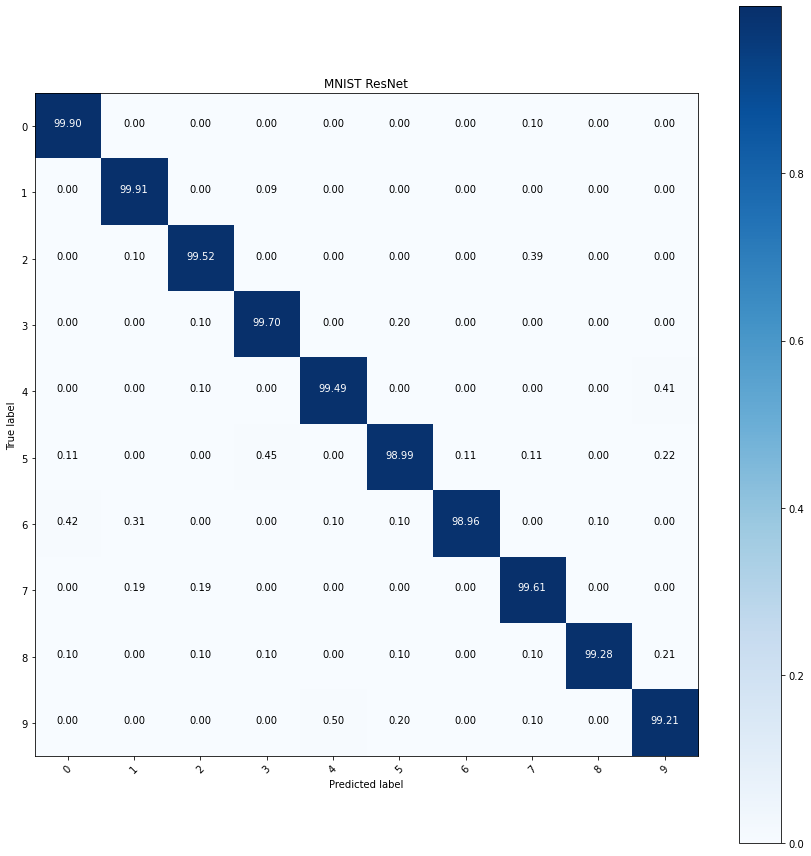

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    fig = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%.2f' % (cm[i, j] * 100.0),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        
    plt.show()

#Mnist ResNet
cm = metrics.confusion_matrix( mnist_lab_list, mnist_prd_list)
plot_confusion_matrix(cm,
                      ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
                      normalize=True,
                      title='MNIST ResNet')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Normalized confusion matrix


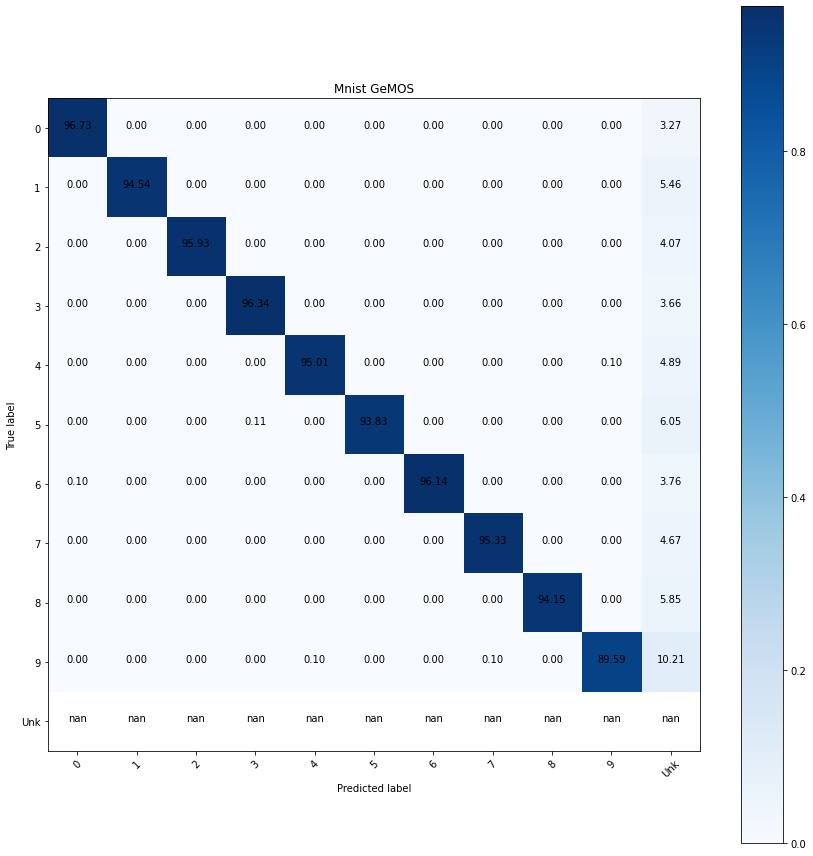

In [7]:
#Mnist ResNet+GeMOS
scr_np = np.asarray(mnist_scr_list)
prd_np = np.asarray(mnist_prd_list)
prd_np[scr_np < 0.85] = args['num_classes']
cm = metrics.confusion_matrix(mnist_lab_list, prd_np)
plot_confusion_matrix(cm,
                      ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','Unk'],
                      normalize=True,
                      title='Mnist GeMOS')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Normalized confusion matrix


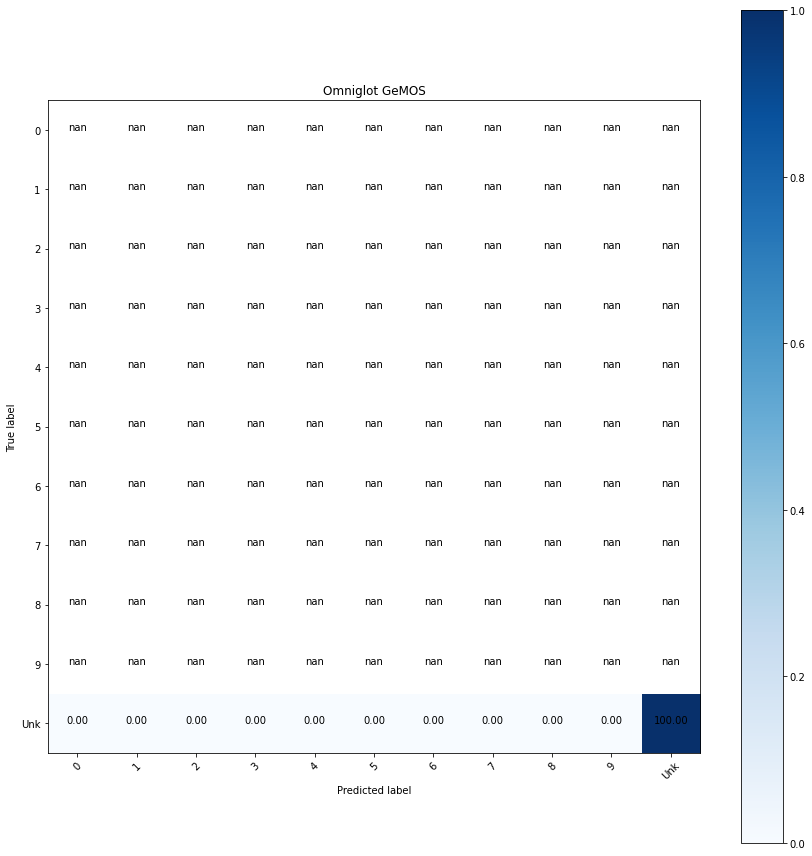

In [8]:
#Omniglot ResNet+GeMOS
scr_np = np.asarray(omniglot_scr_list)
prd_np = np.asarray(omniglot_prd_list)
lab_np = np.asarray(omniglot_lab_list)
lab_np[:] = args['num_classes']
prd_np[scr_np < 0.85] = args['num_classes']
cm = metrics.confusion_matrix(lab_np, prd_np ,labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plot_confusion_matrix(cm,
                      ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','Unk'],
                      normalize=True,
                      title='Omniglot GeMOS')

Normalized confusion matrix


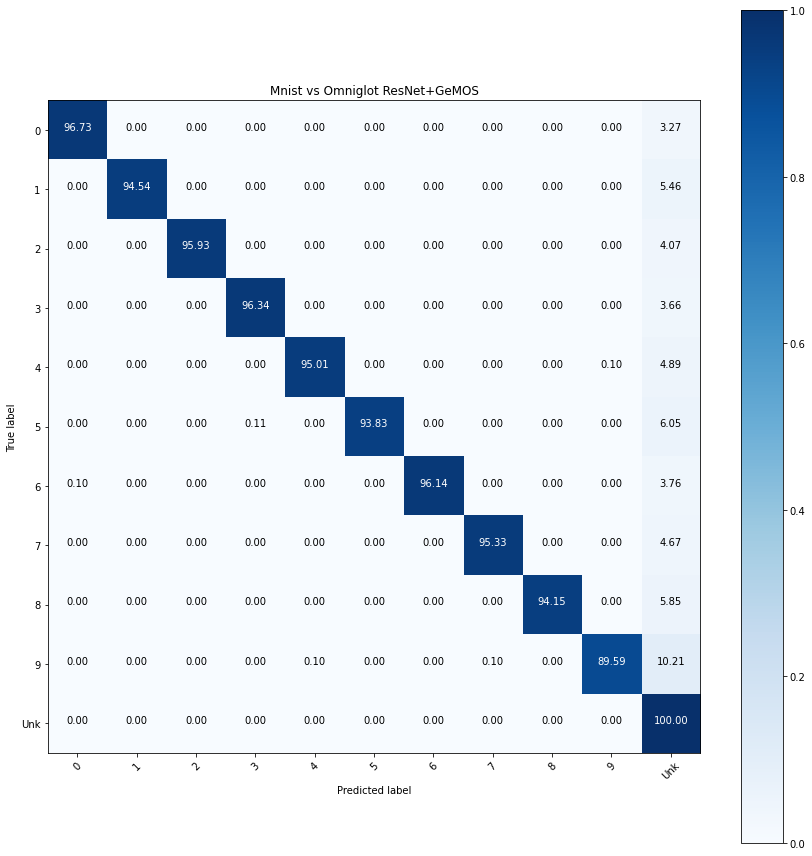

In [9]:
#Mnist vs Omniglot ResNet+GeMOS
scr_np = np.asarray(mnist_scr_list + omniglot_scr_list)
prd_np = np.asarray(mnist_prd_list + omniglot_prd_list)
lab_np = np.asarray(mnist_lab_list + omniglot_lab_list)
lab_np[len(mnist_lab_list):] = args['num_classes']
prd_np[scr_np < 0.85] = args['num_classes']
cm = metrics.confusion_matrix(lab_np, prd_np)
plot_confusion_matrix(cm,
                      ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','Unk'],
                      normalize=True,
                      title='Mnist vs Omniglot ResNet+GeMOS')

#Image Samples

Mnist Resnet


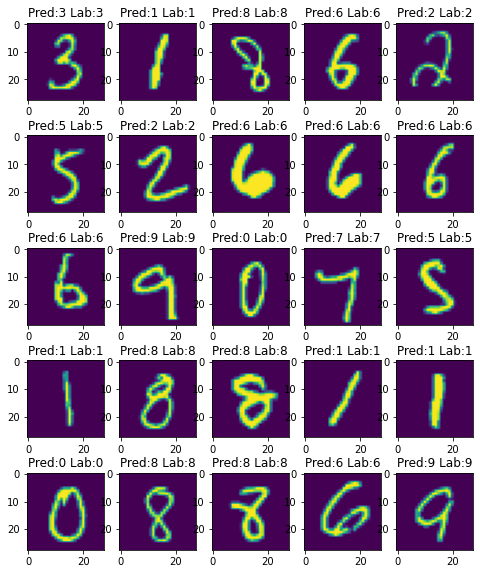

In [10]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=[8, 10])

print('Mnist Resnet')
# plot simple image
for i, axi in enumerate(ax.flat):
    img = mnist_inps[i].cpu()[0,:,:]
    axi.imshow(img)
    axi.set_title('Pred:%d Lab:%d' % (mnist_inps_prd[i] , mnist_inps_lab[i]))

plt.show()

Mnist GeMOS


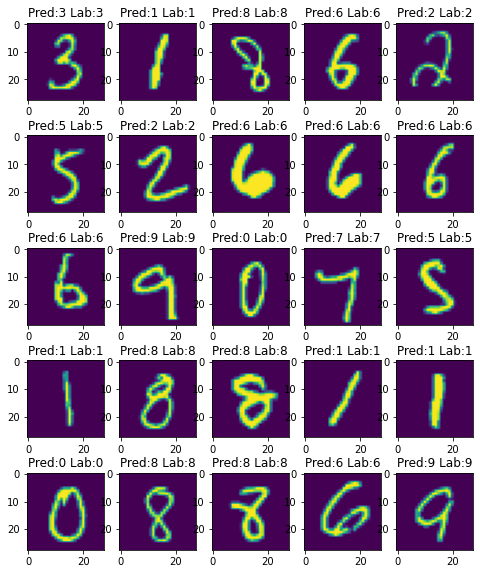

In [11]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=[8, 10])

print('Mnist GeMOS')
# plot simple image
for i, axi in enumerate(ax.flat):
    img = mnist_inps[i].cpu()[0,:,:]
    axi.imshow(img)
    if mnist_inps_scr[i] < 0.85:
      scr = 'Unk'
    else:
      scr = str(mnist_inps_prd[i])
    axi.set_title('Pred:%s Lab:%d' % (scr , mnist_inps_lab[i]))

plt.show()

Omniglot GeMOS


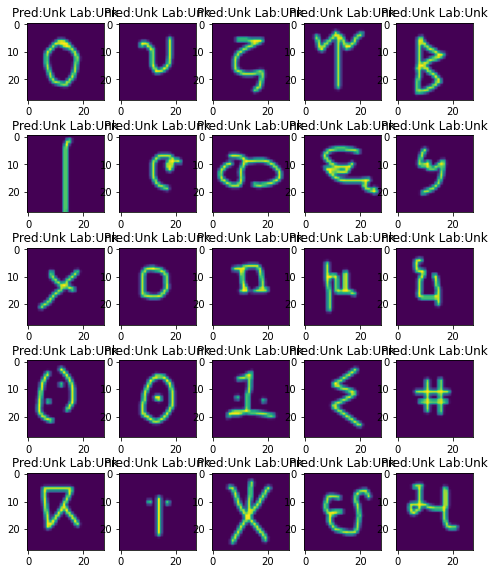

In [12]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=[8, 10])

print('Omniglot GeMOS')
# plot simple image
for i, axi in enumerate(ax.flat):
    img = omniglot_inps[i].cpu()[0,:,:]
    axi.imshow(img)
    if omniglot_inps_scr[i] < 0.85:
      scr = 'Unk'
    else:
      scr = str(omniglot_inps_prd[i])
    axi.set_title('Pred:%s Lab:%s' % (scr , 'Unk'))

plt.show()